## Setup

In [1]:
# Load helpers and custom dataset class
from __init__ import PricingWizardDataset, regression_accuracy, threshold_accuracy, drop_helpers

# Data manipulation 
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

# Data preprocessing
from utils.DataTransformation import base_regression_pipeline



In [2]:
# Data loading
data = PricingWizardDataset(
    filename = 'post_preprocessing_without_dummies.csv'
)

Dataset Loaded: post_preprocessing_without_dummies
	Number of Rows: 283055
	Number of Columns: 22
	Outlier Removal: True
	Train Size: 0.8
	Test Size: 0.2
	Random State: 42


# REGULARIZED REGRESSION

#### Decription
This notebook explores Ridge and Lasso regularization methods for regression to see if performance over methods tried in the base regression notebook can be improved. We found in our initial modeling attempt for the base regression model that the sparsity of one hot encoding all categorical columns left to overfitting (to few samples of unique combinations), therefore we will skip the inital attempt and go to the second version - similar, but with the added bennefit of mapping unique or few cases to 'other' or a less granular category. 

We will attempt to fit ridge and lasso regression models for both the remaining approaches, and evaluate which performance the best. 

### MODEL VERSION 1
Model version 1 uses OHE for brand and subsubsub category name. The preprocessing entails replace rare cases, i.e. cases that appear less than some threshold, with some more generic, more popular category

#### `1. Ridge Regression`

We will try first using Ridge regression from scikit-learn linear models library

In [3]:
# Reset dataset, used during modelling and overwrites any previous changes
data.reset_dataset()

In [4]:
# Similarly as brand, just for subsubsubsub categories
minimum = 30
print(f'Number of subsubsub categories with less than {minimum} listings:', sum(data.df.subsubsubcategory_name.value_counts() < minimum), ' or ', round(sum(data.df.subsubsubcategory_name.value_counts() < minimum) / len(data.df) * 100, 2), '% of dataset')

# Extracting rare subsubsub categories
rare_sub_categories = pd.DataFrame(data.df.subsubsubcategory_name.value_counts()).where(data.df.subsubsubcategory_name.value_counts() < minimum).dropna().index

# Replacing with subcategory name
data.df.loc[data.df[data.df.subsubsubcategory_name.isin(rare_sub_categories)].index, 'subsubsubcategory_name'] = data.df[data.df.subsubsubcategory_name.isin(rare_sub_categories)].subsubcategory_name

Number of subsubsub categories with less than 30 listings: 146  or  0.05 % of dataset


In [5]:
# Similarly as brand, just for subsubsubsub categories
minimum = 30
print(f'Number of subsubsub categories with less than {minimum} listings: {sum(data.df.subsubsubcategory_name.value_counts() < minimum)}  or {round(sum(data.df.subsubsubcategory_name.value_counts() < minimum) / len(data.df) * 100, 2)} % of dataset')

rare_sub_categories = pd.DataFrame(data.df.subsubsubcategory_name.value_counts()).where(data.df.subsubsubcategory_name.value_counts() < minimum).dropna().index
print(rare_sub_categories)

Number of subsubsub categories with less than 30 listings: 2  or 0.0 % of dataset
Index(['Smartphones & Accessories', 'Sportsudstyr'], dtype='object')


In [6]:
# Mapping subsubsubsub categories to more general subsubsub categories
maps = {'Sports shoes': 'Shoes', # Less granular
        'Sportsudstyr': 'Sport', # Less granular
        'Smartphones & Accessories': 'Accessories'} # Their are more apporpriate subsubsub categories, so this is likely the most correct

# Replacing with subcategory name
data.df.loc[data.df[data.df.subsubsubcategory_name.isin(maps.keys())].index, 'subsubsubcategory_name'] = data.df[data.df.subsubsubcategory_name.isin(maps.keys())].subsubsubcategory_name.map(maps)


# Checking for rare subsubsubsub categories again
print(f'Number of subsubsub categories with less than {minimum} listings:', sum(data.df.subsubsubcategory_name.value_counts() < minimum), ' or ', round(sum(data.df.subsubsubcategory_name.value_counts() < minimum) / len(data.df) * 100, 2), '% of dataset')

Number of subsubsub categories with less than 30 listings: 0  or  0.0 % of dataset


In [7]:
# Ordinal Encoding for condition, since this typically follows some sort of order
condition_name = ['Shabby', 'Good but used','Almost as new', 'Never used', 'New, still with price']
data.df.condition_name = data.df.condition_name.apply(lambda x: condition_name.index(x) + 1)

In [8]:
#### MAP INFREUQENT BRANDS TO OTHER
# New columns to use
columns_to_use = ['classified_id', 'log_listing_price', 'condition_name', 'brand_name','subsubsubcategory_name']

# Drop unused columns
data.df = data.df[columns_to_use]

# OHE columns
data.apply_function(pd.get_dummies, columns=['brand_name', 'subsubsubcategory_name'])

# Length of columns
print(f'Old length of columns: ', len(data.df.columns))

# Extracting infrequent brands
infrequent_brands = (data.df[[col for col in data.df.columns if 'brand' in col]].sum(axis=0).sort_values(ascending=True) < 30)
infrequent_brands = infrequent_brands[infrequent_brands == True].index

# Assigning 'other' to brands that are in infrequent_brands
data.df['brand_name_other'] = data.df[infrequent_brands].sum(axis=1)
data.df = data.df.drop(columns=infrequent_brands)

# Length of columns
print(f'New length of columns: ', len(data.df.columns))


Old length of columns:  1049
New length of columns:  830


In [9]:
# Printing sum of columns to see if process was successful
data.df.iloc[:, 3:].sum(axis=0).sort_values(ascending=True).head(20)

subsubsubcategory_name_Scrub & exfoliation    30
subsubsubcategory_name_Makeup brushes         30
brand_name_Unassigned_Waist bags              30
subsubsubcategory_name_Facial makeup          30
brand_name_Unassigned_Denim jackets           30
brand_name_Unassigned_Makeup                  30
brand_name_Unassigned_Bæreudstyr              31
brand_name_Unassigned_Hats                    31
brand_name_Unassigned_Homewear                31
subsubsubcategory_name_Bæreudstyr             31
subsubsubcategory_name_Concealer              31
brand_name_Unassigned_Other jewelry           31
brand_name_Unassigned_Ties                    32
brand_name_Unassigned_Kimonos                 32
subsubsubcategory_name_Tablecloths            32
brand_name_Unassigned_Eau de Toilette         34
brand_name_Unassigned_Creme                   34
subsubsubcategory_name_Lip products           34
brand_name_Unassigned_Spejle                  34
brand_name_Unassigned_Other sportswear        34
dtype: int64

In [10]:
# Ridge regression params
param_grid = {'alpha': np.logspace(-3, 3, 13)}

# Instantiate model
model = Ridge() 

# Grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)


# Train-test split
X_train, X_test, y_train, y_test = data.stratify_train_test_split(y_column='log_listing_price', val_size=0)

Dependent variable distribution is equal across all subsets


In [11]:
# Fitting model (without classified_id)
grid_search.fit(drop_helpers(X_train), y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03])},
             return_train_score=True, scoring='neg_mean_squared_error')

In [12]:
# Mean test score
grid_search.cv_results_['mean_test_score']

array([-0.38151486, -0.3815147 , -0.38151418, -0.38151259, -0.38150793,
       -0.38149641, -0.38148405, -0.38159368, -0.38269203, -0.38886637,
       -0.41176268, -0.46629925, -0.5539595 ])

Not a ton of differences across the different test scores

In [13]:
# Best model
best_model_ridge = grid_search.best_estimator_

In [14]:
# Accuracy of test set
prediction = best_model_ridge.predict(drop_helpers(X_test))

# Log Scale
regression_accuracy(prediction, y_test)
threshold_accuracy(prediction, y_test)
print('Residuals mean:', np.mean(prediction - y_test))
print('Residuals std:', np.std(prediction - y_test))

print('\n\nScaling back to original values')
regression_accuracy(np.exp(prediction),np.exp(y_test))
threshold_accuracy(np.exp(prediction),np.exp(y_test), p=0.1)
print('Residuals mean:', np.mean(np.exp(prediction) - np.exp(y_test)))
print('Residuals std:', np.std(np.exp(prediction) - np.exp(y_test)))



R2 Score: 0.6060281080749564
MSE: 0.37958332989970334
MAE 0.4704520986562844
RMSE 0.6161033435225809
Threshold Accuracy 0.39842080161099436
Residuals mean: 0.0002291658389229984
Residuals std: 0.6161033009023094


Scaling back to original values
R2 Score: 0.4562210332121559
MSE: 161713.8828494586
MAE 191.055882600751
RMSE 402.1366469863927
Threshold Accuracy 0.15161364399145041
Residuals mean: -73.55284203247682
Residuals std: 395.3528326424438


Pretty descent test accuracy. Still don't see the best results for upscaled data, but we will look into what may cause the model to predict wrong later

#### `2. Lasso`

In [23]:
# Instantiate model
model = Lasso()

# Grid search
grid_search_lasso = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

In [24]:
# Fitting model (without classified_id)
grid_search_lasso.fit(drop_helpers(X_train), y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03])},
             return_train_score=True, scoring='neg_mean_squared_error')

In [25]:
# Mean test score
grid_search_lasso.cv_results_['mean_test_score']# Best params

array([-0.53246474, -0.66084426, -0.78005832, -0.87298098, -0.9459755 ,
       -0.97026983, -0.97026983, -0.97026983, -0.97026983, -0.97026983,
       -0.97026983, -0.97026983, -0.97026983])

In [28]:
# Best lasso grid search alpha
grid_search_lasso.best_params_

{'alpha': 0.001}

In [29]:
# Best model
best_model_lasso = grid_search_lasso.best_estimator_

In [30]:
# Accuracy of test set
prediction = best_model_lasso.predict(drop_helpers(X_test))

regression_accuracy(prediction, y_test)
threshold_accuracy(prediction, y_test)

print('\n\nScaling back to original values')
regression_accuracy(np.exp(prediction), np.exp(y_test))
threshold_accuracy(np.exp(prediction), np.exp(y_test), p=0.1)

R2 Score: 0.4513645834432648
MSE: 0.528598264459786
MAE 0.5628633581553512
RMSE 0.727047635619418
Threshold Accuracy 0.32723322322516823


Scaling back to original values
R2 Score: 0.2753817384351954
MSE: 215493.4997825824
MAE 221.3422904536927
RMSE 464.21277425614045
Threshold Accuracy 0.11699139743159456


Compared to Ridge it's quite inferior performance

In [37]:
# Coefficients
best_model_ridge.coef_

# Plotting coefficients
columns = drop_helpers(X_train).columns

# Dataframe with coefficients
coefficients = pd.DataFrame({'feature': columns, 'coefficient': best_model_lasso.coef_})

# Sorting gw≤
coefficients.sort_values(by='coefficient', ascending=False).head()

,feature,coefficient
218,brand_name_Louis Vuitton,1.380538
184,brand_name_Joseph CPH,1.093134
246,brand_name_Moncler,1.078468
825,subsubsubcategory_name_iPhones,1.073274
363,brand_name_Stone Island,1.063133


### Evaluating best performance regularization model

In [49]:
# Get best Ridge model
best_model = grid_search.best_estimator_

In [36]:
# Feature importance for base model
# Get the coefficients of the base model
coefficients = best_model.coef_

# Get the column names
column_names = drop_helpers(X_train).columns

# Create a dataframe to store the feature importance
feature_importance = pd.DataFrame({'Feature': column_names, 'Importance': coefficients})

feature_importance.sort_values(by='Importance', ascending=False).head(20)

,Feature,Importance
49,brand_name_Bottega Veneta,1.887268
89,brand_name_Céline,1.819996
252,brand_name_Mulberry,1.740232
218,brand_name_Louis Vuitton,1.734284
32,brand_name_Balenciaga,1.679472
166,brand_name_I Blame Lulu,1.634660
6,brand_name_AF Agger,1.608670
158,brand_name_Hermès,1.537608
315,brand_name_Proenza Schouler,1.522443
143,brand_name_Gucci,1.507903


Compared to base versions of the model, we see coefficients that behave much more as we'd like. Moreover, we se some of the strongest coefficience are for relatively expensive brands, something that that makes quite good sense.

##### Evaluating wrong predictions

In [38]:
# Extracting dataset
df = data.raw_df

# Filtering to only include test listings
df = df[df.classified_id.isin(X_test.classified_id)]
df = df.iloc[:, :14] # Removing redundant columns

# Adding predictions
X_test_copy = X_test.copy()
X_test_copy['prediction'] = np.exp(prediction)
X_test_copy['difference'] = abs(X_test_copy.prediction - np.exp(y_test))
df = df.merge(X_test_copy[['classified_id', 'prediction', 'difference']], on='classified_id')

In [39]:
df.sort_values(by='difference', ascending=False).head(20)   

,classified_id,listed_at_date,user_id,classified_price,listing_price,favourites,viewed_count,brand_name,condition_name,color_name,category_name,subcategory_name,subsubcategory_name,subsubsubcategory_name,prediction,difference
15101,30493281,2023-09-14,1819766,5850,10500,13,125,Gucci,Good but used,Brown,Women,Women,Women,Crossbody bags,1111.942617,9389.057383
44492,31227022,2023-10-19,2350675,6000,10000,0,32,Unassigned_Computere,"New, still with price",Grey,Electronics,Electronics,Electronics,Computere,1333.034384,8667.965616
4021,31488693,2023-11-02,2309769,5000,10000,10,167,Jordan,"New, still with price",Black,Men,Men,Men,Sneakers,1359.225547,8641.774453
31533,31598565,2023-11-07,1867625,7500,10500,11,168,Céline,Never used,Rust,Women,Women,Women,Crossbody bags,2237.072362,8263.927638
2064,31618256,2023-11-08,2228789,5000,9000,0,152,Jordan,Good but used,Brown,Men,Men,Men,Sneakers,760.686357,8240.313643
11994,31122380,2023-10-15,1057953,7000,9000,29,240,Louis Vuitton,Good but used,Brown,Women,Women,Women,Håndtasker,1377.832095,7623.167905
28469,30867387,2023-10-02,2307950,1350,8056,1,57,Nike,Almost as new,Turquise,Men,Men,Men,Shoes,449.704494,7607.295506
31546,30393356,2023-09-09,2293983,7000,8000,0,22,Unassigned_Computere,Almost as new,Black,Electronics,Electronics,Electronics,Computere,905.282415,7095.717585
24237,31829709,2023-11-21,1639916,3100,6969,12,103,Nike,Almost as new,Black,Men,Men,Men,Sneakers,484.867820,6485.132180
24338,31382457,2023-10-27,1298572,7500,8500,5,81,Moncler,Almost as new,Multi,Women,Women,Clothes,Down jackets,2122.643039,6378.356961


We can see the model is not super good with predicting expensive listings. The skewed distribution in the data, and tendency of listing prices to be concentrated below 1000, seems to make the model struggle with making accurate prediction for high end products, which are more infrequent in the dataset. This makes quite good sense, considering that their is no linear relationship between the independent variables and the listing prices in these cases. Therefore, this kind of relationship might be the task of a neural network or another algorithm capable of mapping these non-linear relationships.

### MODEL VERSION 2
Model version 2 uses an alternative encoding method, where the mean listing price is used as an alternative encoding method for the listings

#### `1. Ridge Regression`

```markdown
Generally this attempt is not expected to improve performance much, as previous coeffcents did not need much penalisation, we will try it anyways as it proved superior in earlier attempts. This encoding method includes using historical listing prices to generate an alternative categorical relationship that hopefully carries more information about the relationship between brands, i.e. that Burberry and Louis Vuitton is closer and that Nike and Addidas are closer
```

In [38]:
# Reset dataset
data.reset_dataset()

# Apply base regression pipeline
data.apply_function(base_regression_pipeline)

In [39]:
data.head()

,classified_id,log_listing_price,brand_name,condition_name,subsubsubcategory_name
0,30343099,7.170120,6.880371,3,6.421452
1,30346312,5.860786,6.108272,3,5.040240
2,30364278,4.795791,5.161306,2,5.616803
3,30406315,6.111467,5.705055,5,5.423886
4,30420441,6.398595,6.880371,4,6.421452


In [40]:
# Train-test split
X_train, X_test, y_train, y_test = data.stratify_train_test_split(y_column='log_listing_price', val_size=0)

# Model
model_2 = Ridge()
grid_search_model_2 = GridSearchCV(model_2, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

# Fitting model (without classified_id)
grid_search_model_2.fit(drop_helpers(X_train), y_train)

Dependent variable distribution is equal across all subsets


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03])},
             return_train_score=True, scoring='neg_mean_squared_error')

In [41]:
grid_search_model_2.cv_results_['mean_test_score']

array([-0.44096407, -0.44096407, -0.44096407, -0.44096407, -0.44096407,
       -0.44096407, -0.44096407, -0.44096407, -0.44096407, -0.44096411,
       -0.44096456, -0.44096925, -0.44101598])

In [42]:
# Mean test score
print('Mean test scores', grid_search_model_2.cv_results_['mean_test_score'])

# Best model
ridge_best_model_2 = grid_search_model_2.best_estimator_

# Best params
print('Best params', grid_search_model_2.best_params_)

Mean test scores [-0.44096407 -0.44096407 -0.44096407 -0.44096407 -0.44096407 -0.44096407
 -0.44096407 -0.44096407 -0.44096407 -0.44096411 -0.44096456 -0.44096925
 -0.44101598]
Best params {'alpha': 3.1622776601683795}


In [43]:
# Accuracy of test set
prediction = ridge_best_model_2.predict(drop_helpers(X_test))

print('Accuracy Metrics (Log Scaled)')
regression_accuracy(prediction, y_test)
# Ressidual
print(f'Average Residuals: {np.mean(prediction - y_test):.2f}')
print(f'STD Residuals: {np.std(prediction - y_test):.2f}')

# Accuracy on regular scale
print('\nAccuracy Metrics (Regular Scale)')
regression_accuracy(prediction, y_test, scale_up=True)
threshold_accuracy(prediction, y_test, scale_up=True, p=0.2)
print('Max prediction', max(np.exp(prediction)))
print('Min prediction', min(np.exp(y_test)))
# Ressidual
print(f'Average Residuals: {np.mean(np.exp(prediction) - np.exp(y_test)):.2f}')
print(f'STD Residuals: {np.std(np.exp(prediction) - np.exp(y_test)):.2f}')


Accuracy Metrics (Log Scaled)
R2 Score: 0.5454074990136324
MSE: 0.4379899652959754
MAE 0.5134090755993848
RMSE 0.6618081030751856
Average Residuals: -0.00
STD Residuals: 0.66

Accuracy Metrics (Regular Scale)
R2 Score: 0.34916555932354665
MSE: 193551.00311374842
MAE 211.42112503297727
RMSE 439.94431819691505
Threshold Accuracy 0.2563812686580347
Max prediction 3016.6415036463745
Min prediction 6.0
Average Residuals: -85.05
STD Residuals: 431.65


#### `2. Lasso Regression`

In [44]:
# Model
new_lasso = Lasso()
gs_lasso = GridSearchCV(new_lasso, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

# Fitting model (without classified_id)
gs_lasso.fit(drop_helpers(X_train), y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03])},
             return_train_score=True, scoring='neg_mean_squared_error')

In [45]:
# Mean test score
print('Mean test scores', gs_lasso.cv_results_['mean_test_score'])

# Best model
best_model = gs_lasso.best_estimator_

# Best params
print('Best params', gs_lasso.best_params_)

Mean test scores [-0.44096926 -0.44101621 -0.44148631 -0.44618906 -0.49322234 -0.73738142
 -0.97026983 -0.97026983 -0.97026983 -0.97026983 -0.97026983 -0.97026983
 -0.97026983]
Best params {'alpha': 0.001}


In [46]:
# Best model
best_model = gs_lasso.best_estimator_

In [47]:
# Accuracy of test set
prediction = best_model.predict(drop_helpers(X_test))

print('Accuracy Metrics (Log Scaled)')
regression_accuracy(prediction, y_test)
# Ressidual
print(f'Average Residuals: {np.mean(prediction - y_test):.2f}')
print(f'STD Residuals: {np.std(prediction - y_test):.2f}')

# Accuracy on regular scale
print('\nAccuracy Metrics (Regular Scale)')
regression_accuracy(np.exp(prediction), np.exp(y_test))
threshold_accuracy(np.exp(prediction), np.exp(y_test), p=0.2)
print('Max prediction', max(np.exp(prediction)))
print('Min prediction', min(np.exp(y_test)))
# Ressidual
print(f'Average Residuals: {np.mean(np.exp(prediction) - np.exp(y_test)):.2f}')
print(f'STD Residuals: {np.std(np.exp(prediction) - np.exp(y_test)):.2f}')


Accuracy Metrics (Log Scaled)
R2 Score: 0.5454072048005749
MSE: 0.4379902487638428
MAE 0.5134375519449209
RMSE 0.6618083172368286
Average Residuals: -0.00
STD Residuals: 0.66

Accuracy Metrics (Regular Scale)
R2 Score: 0.3486256664441917
MSE: 193711.56131694446
MAE 211.39896058815867
RMSE 440.12675596576094
Threshold Accuracy 0.2565225839501157
Max prediction 2990.5200701151284
Min prediction 6.0
Average Residuals: -85.58
STD Residuals: 431.73


Very similar results, a bit expected as the different coefficient penalities are not expected to cause mcuh difference to the results, but generally for the upscaled predictions Ridge did a bit better

In [48]:
# Coefficients
coefficients = best_model.coef_

# Get the column names
column_names = drop_helpers(X_train).columns

# Create a dataframe to store the feature importance
feature_importance = pd.DataFrame({'Feature': column_names, 'Importance': coefficients})

feature_importance.sort_values(by='Importance', ascending=False).head(20)


,Feature,Importance
0,brand_name,0.821906
2,subsubsubcategory_name,0.497035
1,condition_name,0.152521


#### Examining wrong predictions

In [52]:
# Best model
best_model = grid_search_model_2.best_estimator_


In [53]:
# Extracting dataset
df = data.raw_df

# Filtering to only include test listings
df = df[df.classified_id.isin(X_test.classified_id)]
df = df.iloc[:, :14] # Removing redundant columns

# Adding predictions
X_test_copy = X_test.copy()
X_test_copy['prediction'] = prediction
X_test_copy['difference'] = abs(X_test_copy.prediction - np.exp(y_test))
df = df.merge(X_test_copy[['classified_id', 'prediction', 'difference']], on='classified_id')

In [54]:
df.sort_values(by='difference', ascending=False).head(20)

,classified_id,listed_at_date,user_id,classified_price,listing_price,favourites,viewed_count,brand_name,condition_name,color_name,category_name,subcategory_name,subsubcategory_name,subsubsubcategory_name,prediction,difference
15101,30493281,2023-09-14,1819766,5850,10500,13,125,Gucci,Good but used,Brown,Women,Women,Women,Crossbody bags,6.528492,10494.471508
31533,31598565,2023-11-07,1867625,7500,10500,11,168,Céline,Never used,Rust,Women,Women,Women,Crossbody bags,7.145759,10493.854241
4021,31488693,2023-11-02,2309769,5000,10000,10,167,Jordan,"New, still with price",Black,Men,Men,Men,Sneakers,7.193243,9993.806757
44492,31227022,2023-10-19,2350675,6000,10000,0,32,Unassigned_Computere,"New, still with price",Grey,Electronics,Electronics,Electronics,Computere,7.455570,9993.544430
2064,31618256,2023-11-08,2228789,5000,9000,0,152,Jordan,Good but used,Brown,Men,Men,Men,Sneakers,6.735680,8994.264320
11994,31122380,2023-10-15,1057953,7000,9000,29,240,Louis Vuitton,Good but used,Brown,Women,Women,Women,Håndtasker,6.867075,8994.132925
24338,31382457,2023-10-27,1298572,7500,8500,5,81,Moncler,Almost as new,Multi,Women,Women,Clothes,Down jackets,7.007922,8493.992078
31776,30878694,2023-10-03,1891706,5000,8400,6,123,Bottega Veneta,Never used,NaN,Women,Women,Women,Shoulder bags,7.300272,8393.699728
28469,30867387,2023-10-02,2307950,1350,8056,1,57,Nike,Almost as new,Turquise,Men,Men,Men,Shoes,6.104808,8050.895192
13822,30851760,2023-10-02,2551131,6800,8000,8,149,Gucci,Never used,Light grey,Women,Women,Women,Crossbody bags,6.833534,7994.166466


```markdown
Similarly we see the model struggles learning accurate patterns for these more 'extreme' listings. Generally the wrong predictions are quite expensive brands and categories. As it can also be seen below, average listing price for gucci, louis vuitton and some of the others above are far lower than those, implying these extremely wrong predictions may be 'outliers'
```

In [55]:
print('Gucci', df[df.brand_name == 'Gucci'].listing_price.mean())
print('Louis Vuitton', df[df.brand_name == 'Louis Vuitton'].listing_price.mean())
print('Céline', df[df.brand_name == 'Céline'].listing_price.mean())

Gucci 1209.8969072164948
Louis Vuitton 1850.0112359550562
Céline 1873.5588235294117


In [56]:
# Get the coefficients of the base model
coefficients = best_model.coef_

# Get the column names
column_names = drop_helpers(X_train).columns

# Create a dataframe to store the feature importance
feature_importance = pd.DataFrame({'Feature': column_names, 'Importance': coefficients})

feature_importance.sort_values(by='Importance', ascending=False).head(20)

,Feature,Importance
0,brand_name,0.822899
2,subsubsubcategory_name,0.500381
1,condition_name,0.153367


### Conclussion
From the 4 trained models above, we see that the first model version using Ridge regression with one hot encoding works best. 

## Residual Analysis on Best Model

R2 Score: 0.6060281080749564
MSE: 0.37958332989970334
MAE 0.4704520986562844
RMSE 0.6161033435225809
8.24604877913504
2.8507164787931125
0.0002291658389229984
0.6161033009023094


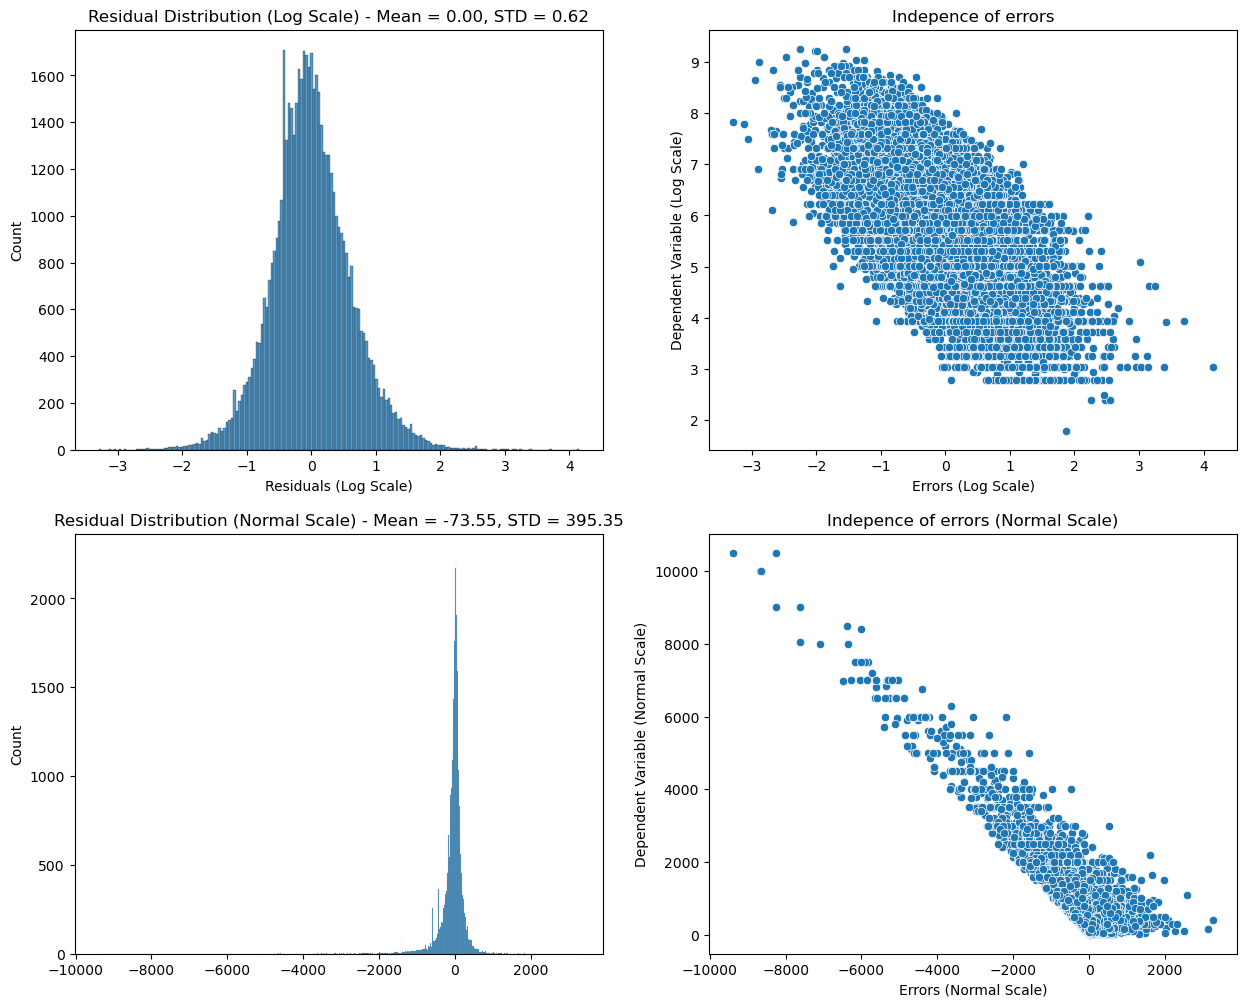

In [15]:
# Accuracy of training set
prediction = best_model_ridge.predict(drop_helpers(X_test))

regression_accuracy(prediction, y_test)
print(max(prediction))
print(min(prediction))


# Ressidual
print(np.mean(prediction - y_test))
print(np.std(prediction - y_test))

fig, axs = plt.subplots(2,2, figsize=(15, 12))
axs = axs.flatten()
# Residual Distribution
axs[0].set_title(f'Residual Distribution (Log Scale) - Mean = {np.mean(prediction - y_test):.2f}, STD = {np.std(prediction - y_test):.2f}')
axs[0].set_xlabel('Residuals (Log Scale)')
sns.histplot(prediction - y_test, ax=axs[0])

# Residuals vs prediction plot
axs[1].set_title('Indepence of errors')
sns.scatterplot(x=(prediction - y_test), y=y_test, ax=axs[1])
axs[1].set_xlabel('Errors (Log Scale)')
axs[1].set_ylabel('Dependent Variable (Log Scale)')


# Residual Distribution
axs[2].set_title(f'Residual Distribution (Normal Scale) - Mean = {np.mean(np.exp(prediction) - np.exp(y_test)):.2f}, STD = {np.std(np.exp(prediction) - np.exp(y_test)):.2f}')
sns.histplot(np.exp(prediction) - np.exp(y_test), ax=axs[2])
axs[3].set_xlabel('Residuals (Normal Scale)')
axs[3].set_title('Indepence of errors (Normal Scale)')
sns.scatterplot(x=(np.exp(prediction) - np.exp(y_test)), y=np.exp(y_test), ax=axs[3])
axs[3].set_xlabel('Errors (Normal Scale)')
axs[3].set_ylabel('Dependent Variable (Normal Scale)')
plt.show()

### Better than before, but still not great